In [1]:
# Feature 1:
# Trinket type
# interpretable: categorical
# orig: one-hot-encoded
# explain: categorical
# model: one-hot-encoded

# Feature 2:
# Trinket color
# interpretable: english
# orig: html
# explain: html
# model: one-hot-encoded

# Feature 3:
# Trinket age
# interpretable: numeric
# orig: standardized numeric
# explain: standardized numeric
# model: standardized numeric

# Feature 4:
# Trinket weight
# interpretable: numeric
# orig: numeric
# explain: numeric
# model: combined with 5

# Feature 5:
# Trinket height
# interpretable: numeric
# orig: numeric
# explain: numeric
# model: combined with 5

# Target
# Trinket price

In [2]:
import importlib

from pyreal.explainers.lfc import simple_counterfactual_contribution as scc
from pyreal.explainers.lfc import local_feature_contribution as lfc
importlib.reload(scc)
import pandas as pd
from sklearn.linear_model import LinearRegression
import random

random.seed(100)

def random_color():
    cat = random.randint(0, 2)
    major = random.randint(200, 254)
    minor1 = random.randint(1, 50)
    minor2 = random.randint(1, 50)
    if cat == 0:
        return '#%02x%02x%02x' % (major, minor1, minor2), cat
    if cat == 1:
        return '#%02x%02x%02x' % (minor1, major, minor2), cat
    if cat == 2:
        return '#%02x%02x%02x' % (minor1, minor2, major), cat

colors = []
cats = []
for i in range(500):
    color, cat = random_color()
    colors.append(color)
    cats.append(cat)

types = random.choices(["foo", "bar", "foobar"], k=500)

age = random.choices(range(20, 100), k=500)

weight = [random.uniform(10, 90) for i in range(500)]
height = [random.uniform(10, 90) for i in range(500)]

data = pd.DataFrame([colors, types, age, weight, height], index=["color", "type", "age", "weight", "height"]).transpose()

prices = []
for i in range(500):
    price = cats[i] * 20 * (1+random.uniform(-.01, .01))
    price += ["foo", "bar", "foobar"].index(types[i]) * 100 * (1+random.uniform(-.01, .01))
    price += ((age[i] - 20) / 100) * 80 * (1+random.uniform(-.01, .01))
    price += (max(weight[i], height[i])) * 2 * (1+random.uniform(-.01, .01))
    prices.append(price)
data["price"] = prices
data.to_csv("trinket_data.csv")


In [3]:
from pyreal.transformers import BaseTransformer, OneHotEncoder, DataFrameWrapper, Mappings, MappingsOneHotDecoder, FeatureSelectTransformer
from sklearn.preprocessing import MinMaxScaler

class ColorTransformer(BaseTransformer):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, x_orig):
        return self

    def transform(self, x):
        for col in self.columns:
            x[col] = x[col].apply(hex_to_color_name)
        return x

class MaxAggregator(BaseTransformer):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, x):
        column_name = "MAX("
        column_name += ",".join(self.columns)
        column_name += ")"
        x[column_name] = x[self.columns].max(axis=1)
        x = x.drop(self.columns, axis=1)
        return x

def hex_to_color_name(h):
    h = h.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return ["red", "green", "blue"][rgb.index(max(rgb))]

colorTransformer = ColorTransformer(columns = ["color"])
typeEncoder = OneHotEncoder(columns = ["type"])
colorEncoder = OneHotEncoder(columns = ["color"])
maxAggregator = MaxAggregator(columns=["weight", "height"])
#scaler = DataFrameWrapper(MinMaxScaler(), columns=["age"])
mappings = Mappings.generate_mappings(categorical_to_one_hot={"type": {"type_foo": "foo", "type_bar": "bar", "type_foobar": "foobar"}})
typeDecoder = MappingsOneHotDecoder(mappings)

data = pd.read_csv("trinket_data.csv", index_col=0)
y = data["price"]
X = data.drop("price", axis=1)

X_orig = typeEncoder.fit_transform(X)
data_orig = X_orig
data_orig["price"] = y
data_orig.to_csv("trinket_data_orig.csv")

X_model = colorTransformer.fit_transform(X)
X_model = typeEncoder.fit_transform(X_model)
X_model = colorEncoder.fit_transform(X_model)
X_model = maxAggregator.fit_transform(X_model)

featureSelect = FeatureSelectTransformer(X_model.columns)


model = LinearRegression()
model.fit(X_model[0:400], y[0:400])

print(model.score(X_model[401:], y[401:]))


0.9998228611356162


In [4]:
data_orig =  pd.read_csv("trinket_data_orig.csv", index_col=0)
y_orig = data_orig["price"]
X_orig = data_orig.drop("price", axis=1)

e_transforms = [typeDecoder]
m_transforms = [colorTransformer, colorEncoder, maxAggregator, typeEncoder, featureSelect]
i_transforms = [typeDecoder, colorTransformer]

explainer1 = scc.SimpleCounterfactualContribution(model, X_orig,
                                                 m_transforms=m_transforms,
                                                 e_transforms=e_transforms,
                                                 i_transforms=i_transforms,
                                                 fit_on_init=True)

transforms = [colorTransformer, colorEncoder, maxAggregator, featureSelect]
explainer2 = lfc.LocalFeatureContribution(model, X_orig,
                                          transforms=transforms,
                                          #e_transforms=e_transforms,
                                          i_transforms=i_transforms,
                                          fit_on_init=True)

   age  type_bar  type_foo  type_foobar  color_blue  color_green  color_red  \
0   41       1.0       0.0          0.0         0.0          0.0        1.0   
1   71       0.0       0.0          1.0         0.0          0.0        1.0   
2   90       1.0       0.0          0.0         0.0          1.0        0.0   
3   32       0.0       1.0          0.0         1.0          0.0        0.0   
4   44       0.0       0.0          1.0         0.0          1.0        0.0   

   MAX(weight,height)  
0           68.784567  
1           84.261218  
2           71.574072  
3           83.431874  
4           54.253466  
   age  type_bar  type_foo  type_foobar  color_blue  color_green  color_red  \
0   41       1.0       0.0          0.0         0.0          0.0        1.0   
1   71       0.0       0.0          1.0         0.0          0.0        1.0   
2   90       1.0       0.0          0.0         0.0          1.0        0.0   
3   32       0.0       1.0          0.0         1.0          0.0 

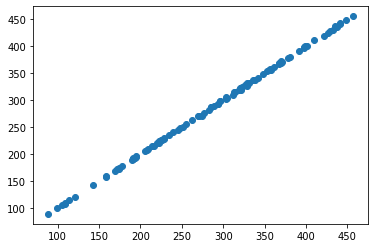

In [5]:
import matplotlib.pyplot as plt
print(X_model[0:5])
print(explainer2.transform_to_x_model(X_orig[0:5]))
plt.scatter(model.predict(explainer1.transform_to_x_model(X_orig[0:100])), y[0:100])


explanation = explainer2.produce(X_orig.iloc[0])
print(explanation)